## Casualty Analysis of Speeding Cases resulting in People Killed outside of Vehicle

There are 36,560 people died in car accidents in 2018, and 26% of the cases are speeding related.

### Research Question
In this notebook we will be analyzing speeding-related traffic crashes in 2015 that resulting the deaths outside of vehicle and exploring the contribution factors. We will use machine learning algorithms to analyze the data.

### Data Loading

The dataset is from Google BigQuery public data [NHTSA Traffic Fatalities](https://console.cloud.google.com/marketplace/product/nhtsa-data/nhtsa-traffic-fatalities?filter=solution-type:dataset&filter=category:public-safety&id=412c019d-62ba-4ee9-af00-04183e9ddb84) and [How to connect to Google BigQuery](https://cloud.google.com/bigquery/docs/quickstarts?hl=en_US)
For more detail about the dataset please visit [NHTSA Fatality Analysis Reporting System](https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars)
Here is the sample SQL code I used to query the data from BigQuery:
```
    SELECT
        ap.*, body_type,
        vehicle_trailing, gross_vehicle_weight_rating, travel_speed,
        previous_recorded_crashes, previous_recorded_suspensions_and_revocations, previous_dwi_convictions,
        previous_speeding_convictions, related_factors_driver_level_1, related_factors_driver_level_2,
        related_factors_driver_level_3, related_factors_driver_level_4, roadway_alignment, roadway_grade,
        roadway_surface_type, roadway_surface_condition, crash_type_name, fatalities_in_vehicle
        FROM (
        SELECT a.consecutive_number, number_of_forms_submitted_for_persons_not_in_motor_vehicles
        number_of_forms_submitted_for_persons_not_in_motor_vehicles, a.day_of_crash, a.month_of_crash,
        day_of_week, a.hour_of_crash, national_highway_system, a.land_use_name, a.functional_system_name,
        route_signing, a.first_harmful_event_name, relation_to_junction_within_interchange_area,              a.relation_to_junction_specific_location_name, type_of_intersection, relation_to_trafficway_name, light_condition_name,
        atmospheric_conditions_name, related_factors_crash_level_1_name, related_factors_crash_level_2_name, related_factors_crash_level_3_name,
        number_of_fatalities, p.vehicle_number, p.rollover, p.age, p.sex, p.person_type, p.injury_severity,
        p.police_reported_alcohol_involvement, p.police_reported_drug_involvement, race
        FROM
        `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015` a
        LEFT JOIN
        `bigquery-public-data.nhtsa_traffic_fatalities.person_2015` p
        ON a.consecutive_number = p.consecutive_number
        WHERE p.person_type = 1
        ) ap
        JOIN
        `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
        ON ap.vehicle_number = v.vehicle_number
        WHERE speeding_related LIKE '%Yes%' and number_of_forms_submitted_for_persons_not_in_motor_vehicles > 0
        LIMIT 200000
```
I wrote is simple [script](bq.py) to convert the data from Google Big Query to Data Frame.
Here you need to save the Google credential file, more details about how to make connection
please see [here](https://cloud.google.com/bigquery/docs/reference/libraries?authuser=1#client-libraries-usage-python).

In [ ]:
import bq

query = """
SELECT * FROM `nhtsa-daisy.fars_2015.fars_2015`
"""

df = bq.to_df(query, "../../Downloads/NHTSA-Daisy-5dde7049e0be.json")

### Data Preprocess and Exploration

#### Create Target
First, we need to create our target.
The target is from the number of total fatalities of the crash minus fatalities inside the car.
If the number bigger than 0, the speeding crash result in people's death outside of vehicle, vise versa.
We create a new column called `death`, which is a binary with value 0 and 1, then we need to plot this column.

0    167454
1     32546
Name: death, dtype: int64


<AxesSubplot:>

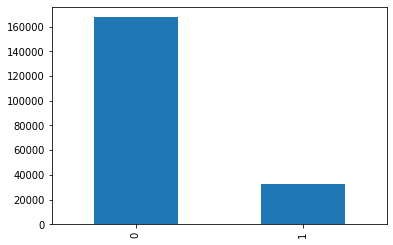

In [3]:
df['death'] = df.apply(lambda row: 1 if (row.number_of_fatalities - row.fatalities_in_vehicle > 0) else 0, axis=1)
print(df['death'].value_counts())
df['death'].value_counts().plot(kind='bar')

As you can see the target is not very balance, we have more than 5 times of class 0 than class 1.
we could up-sample minority class or down-sample majority class.
Here we choose to down-sample majority class (death = 0) to 32546.

1    32546
0    32546
Name: death, dtype: int64


<AxesSubplot:>

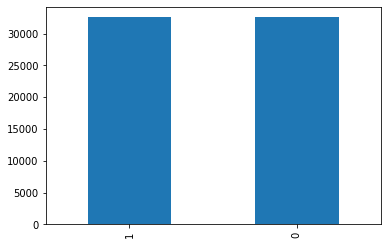

In [4]:
from sklearn.utils import resample
import pandas as pd
df_majority = df[df.death==0]
df_minority = df[df.death==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=32546,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled.death.value_counts())
df_downsampled['death'].value_counts().plot(kind='bar')

Now the number of data point of target is balanced.

#### Data Cleansing and Encoding
Then we need to drop some unnecessary columns to help reduce the computation.

In [5]:
df_downsampled = df_downsampled.drop(['consecutive_number', 'number_of_fatalities', 'fatalities_in_vehicle',
                                      'number_of_forms_submitted_for_persons_not_in_motor_vehicles', 'vehicle_number',
                                      'person_type'], axis=1)

Next we need to encode our categorical data to allow computation.

Based on preliminary research, columns `relation_to_junction_within_interchange_area`, `vehicle_trailing`, `rollover`,
`police_reported_alcohol_involvement`, `police_reported_drug_involvement` and `sex` are primary binary columns, so we
could encode them 0 and 1 according to their value. Because some columns are long string, so we need to strip the text.

In [6]:
df_downsampled["relation_to_junction_within_interchange_area"] = df_downsampled.apply(
    lambda row: 1 if (row.relation_to_junction_within_interchange_area == 'Yes') else 0, axis=1)

df_downsampled['vehicle_trailing'] = df_downsampled['vehicle_trailing'].str[0:3]
df_downsampled['vehicle_trailing'] = df_downsampled.apply(
    lambda row: 0 if (row.vehicle_trailing == 'No ') else 1, axis=1)

df_downsampled['rollover'] = df_downsampled['rollover'].str[0:2]
df_downsampled['rollover'] = df_downsampled.apply(
    lambda row: 0 if (row.rollover == 'No') else 1, axis=1)

df_downsampled['police_reported_alcohol_involvement'] = df_downsampled['police_reported_alcohol_involvement'].str[0:3]
df_downsampled['police_reported_alcohol_involvement'] = df_downsampled.apply(
    lambda row: 1 if (row.police_reported_alcohol_involvement == 'Yes') else 0, axis=1)

df_downsampled['police_reported_drug_involvement'] = df_downsampled['police_reported_drug_involvement'].str[0:3]
df_downsampled['police_reported_drug_involvement'] = df_downsampled.apply(
    lambda row: 1 if (row.police_reported_drug_involvement == 'Yes') else 0, axis=1)

df_downsampled['sex'] = df_downsampled.apply(
    lambda row: 0 if (row.sex == 'Female') else 1, axis=1)

Now we could create predictors (X) and target (y)

In [7]:
X = df_downsampled.drop(['death'], axis=1)
y = df_downsampled['death']

In X there are still some categorical columns, but they are not binary or numeric order, so we need to create dummie
variables.

In [8]:
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

### Feature Selection

In real case, we don't want to feed too many data which would require higher computation power,
and unnecessary columns also could affect your model performance.
Here we use filter features by its importance.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np

extra_tree_forest = ExtraTreesClassifier(n_estimators=10, criterion ='entropy')

extra_tree_forest.fit(X, y)
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 

feature_importance_df = pd.DataFrame({'feature_names':np.array(X.columns),
                                      'feature_importance':np.array(feature_importance)})

Top 10 important features are
- `body_type`: This data element identifies a classification of this vehicle based on its general body configuration,
size, shape, doors, etc.
- `crash_type_name_SINGLE DRIVER, CONFIGURATION C: FORWARD IMPACT, Pedestrian/Animal`: This data element identifies the
attribute that best describes the type of crash this vehicle was involved in based on the “First Harmful Event” and the
precrash circumstances.
- `related_factors_driver_level_1`: This data element records factors related to this driver expressed by the
investigating officer.
- `travel_speed`,
- `crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Drive Off Road`,
- `crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Drive Off Road`,
- `crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Control/Traction Loss`,
- `crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Control/Traction Loss`,
- `roadway_alignment_Straight`,
- `previous_speeding_convictions`

In [10]:
print(list(feature_importance_df.sort_values(by=['feature_importance'], ascending=False)[:10]['feature_names']))

['body_type', 'crash_type_name_SINGLE DRIVER, CONFIGURATION C: FORWARD IMPACT, Pedestrian/Animal', 'related_factors_driver_level_1', 'travel_speed', 'crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Drive Off Road', 'crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Drive Off Road', 'crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Control/Traction Loss', 'crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Control/Traction Loss', 'roadway_alignment_Straight', 'previous_speeding_convictions']


In [11]:
from sklearn.model_selection import train_test_split

X = X[['body_type', 'crash_type_name_SINGLE DRIVER, CONFIGURATION C: FORWARD IMPACT, Pedestrian/Animal', 'related_factors_driver_level_1', 'travel_speed', 'crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Drive Off Road', 'crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Drive Off Road', 'crash_type_name_SINGLE DRIVER, CONFIGURATION A: RIGHT ROADSIDE DEPARTURE, Control/Traction Loss', 'roadway_alignment_Straight', 'crash_type_name_SINGLE DRIVER, CONFIGURATION B: LEFT ROADSIDE DEPARTURE, Control/Traction Loss', 'previous_recorded_suspensions_and_revocations']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd

classifiers = [LogisticRegression(random_state=1234),
               GaussianNB(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::, 1]

    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)

    result_table = result_table.append({'classifiers': cls.__class__.__name__,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'auc': auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)
print(result_table)

                                                                      fpr  \
classifiers                                                                 
LogisticRegression      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
GaussianNB              [0.0, 0.002251688766574931, 0.0022516887665749...   
KNeighborsClassifier    [0.0, 0.028646484863647736, 0.0585439079309482...   
DecisionTreeClassifier  [0.0, 0.0012509382036527395, 0.001250938203652...   
RandomForestClassifier  [0.0, 0.0, 0.00012509382036527395, 0.000125093...   

                                                                      tpr  \
classifiers                                                                 
LogisticRegression      [0.0, 0.0008455127430849137, 0.001570237951443...   
GaussianNB              [0.0, 0.2493054716753231, 0.2500301968836816, ...   
KNeighborsClassifier    [0.0, 0.8241333494383379, 0.9202802270805653, ...   
DecisionTreeClassifier  [0.0, 0.7004469138784878, 0.7020171518299312, ...  

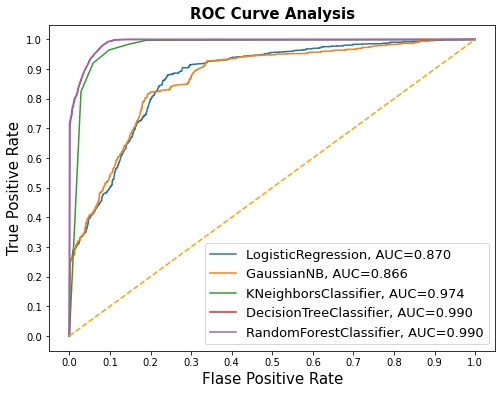

In [13]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()